In [2]:
import pandas as pd
import pickle
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
import torchvision
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import time
import sys
from utils import *
from networks import *
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import hamming_loss


n = 5000
seq_len = 20
h = 512
num_tags = 30
batch_size = 64

gpu = False

df = pd.read_csv('lyric_data.csv', index_col=0)#.iloc[0:200000]
#df = pd.read_csv('lyric_data_small.csv', index_col=0)


# Sometimes the API returns an error message rather than actual lyrics. This removes it
bad_song = df['lyrics'].value_counts().index[0]
df[df['lyrics'] == bad_song] = ''

# only take the ones that we have data for
df.fillna('', inplace=True)
df = df[df['lyrics'] != '']
df = df.drop_duplicates(['artist','song'])

# List of list of tags for each example
tags = [clean_tags(raw) for raw in list(df['tags'])]

# list of tuples of (tag, frequency) in desending order
tf = tag_freq(tags)

# Choose which tags to restrict model too
important_tags = [x[0] for x in tf[0:num_tags]]
important_tags = dict(zip(important_tags, range(len(important_tags))))

# maps each of the tags int 'tags' to an int index
indices = tag2index(tags, important_tags)

# Convert indices to binary vectors of tags
y = np.zeros((len(indices), num_tags))
for i, tags in enumerate(indices):
    for tag in tags:
        y[i, tag] = 1

# Build vocabulary and tokenizer
vect = CountVectorizer(max_features=n, stop_words='english')
vect.fit(df['lyrics'])
vocab = vect.vocabulary_
tok = vect.build_analyzer()


def load_glove(vocab):
    embedding_mat = [np.zeros(50)]
    new_vocab = {}
    new_vocab[''] = 0
    count = 0

    with open('/Users/Hadoop/Desktop/glove.6B.50d.txt') as f:

        for i, line in enumerate(f):

            s = line.split()

            if s[0] in vocab:
                embedding_mat.append(np.asarray(s[1:]))
                new_vocab[s[0]] = count
                count += 1

                if len(list(new_vocab.keys())) == len(list(vocab.keys())):
                    return new_vocab, np.array(embedding_mat)

    embedding_mat.append(np.random.randn(50))
    new_vocab['UNK'] = len(embedding_mat)
    
    return new_vocab, np.array(embedding_mat).astype(np.float32())

# Load glove vectors for word embedding
vocab, glove = load_glove(vocab)


# Convert text to sequence input
features = df['lyrics'].apply(lambda x: sent2seq(x, vocab, tok, seq_len))
features = np.array(list(features))

features = torch.from_numpy(features)
y = torch.from_numpy(y).float()
glove = torch.from_numpy(glove)


torch.Size([64, 100])


In [22]:
class LSTM_Model(nn.Module):

    def __init__(self,h,glove,num_out):
        super(LSTM_Model, self).__init__()

        self.h = h
        self.embed = nn.Embedding(glove.size()[0], glove.size()[1], padding_idx=0 )
        self.embed.weight = nn.Parameter(glove )

        #self.lstm = nn.LSTM(glove.size()[1], h, 1, batch_first=True)
        self.lstm = nn.GRU(glove.size()[1], h, 1, batch_first=True , dropout = .3, bidirectional = False)

        self.output_layer = nn.Linear(h, num_out,bias=False)

        self.params = list(self.embed.parameters()) + list(self.output_layer.parameters()) + list(self.lstm.parameters())
        #self.params =  list(self.output_layer.parameters()) + list(self.lstm.parameters())


    def forward(self,x):

        h0 = Variable(torch.zeros(1, x.size()[0], self.h))
        c0 = Variable(torch.zeros(1, x.size()[0], self.h))

        E = self.embed(x)
        
        z = self.lstm(E, h0)[0][:, -1, :]

        y_hat = F.sigmoid(self.output_layer(z))

        return y_hat

model = LSTM_Model(32,glove,num_tags)

print(model(data).size())

torch.Size([16, 30])


In [23]:
for p in output.parameters():
    print(p.grad)

Variable containing:
-1.4444e-03 -1.6085e-03 -6.3256e-04  ...  -1.5683e-03 -1.2202e-03  1.1343e-04
-1.0188e-03 -9.7500e-04 -5.2843e-04  ...  -3.4567e-04 -1.7049e-04  6.0790e-04
-4.4641e-03 -1.2784e-03  9.6082e-04  ...  -4.7085e-05 -2.3517e-03 -4.8138e-04
                ...                   ⋱                   ...                
-7.7108e-03  4.2762e-03  3.7395e-03  ...   1.1472e-03 -1.2463e-04 -4.7277e-03
-8.6352e-03  3.9344e-03  4.5240e-03  ...   1.7290e-03 -8.9400e-04 -4.9314e-03
-8.2193e-03  3.7746e-03  4.3103e-03  ...   1.6525e-03 -8.5361e-04 -4.6865e-03
[torch.FloatTensor of size 30x512]



In [24]:
bce = torch.nn.BCELoss()

data , target = Variable(features[0:16]) , Variable(y[0:16])
#y_hat = model(data)

embed= model.embed
lstm = model.lstm
output = model.output_layer
h = model.h

def forward(x):

    h0 = Variable(torch.zeros(1, x.size()[0], h))

    E = embed(x)

    z = lstm(E, h0)[0]
    #z.register_hook(lambda grad: print(grad))
    y_hat = F.sigmoid(output(z[:, -1, :]))

    return y_hat,z

y_hat, z= forward(data)

loss= bce(y_hat,target)
loss.backward()


In [29]:
vect2 = vect.copy(deep=True)
vect.inverse_transform(features[i].numpy())

[array(['000', '10', '100', '11', '12', '13', '15', '16', '17', '18', '1st',
        '20', '21', '22', '24', '25', '2nd', '2x', '30', '3x'], 
       dtype='<U16')]

In [31]:
features[i].numpy()

array([ 102, 4978, 3764, 4978, 1644, 2929,  355,  194,  246,  482, 3105,
          4,  725, 1000,  640, 2928,  474, 2487, 4978, 1567])

In [48]:
inv = dict([ (v,k) for k,v in vocab.items()])
inv[len(vocab.keys())+1] = 'UNK'
#inv[0] =

In [69]:
df[df['artist'] == 'Jimi Hendrix']

,file,artist,song,lyrics,tags,timestamp,id
3248,A/E/T/TRAETTV12903CBBD09.json,Jimi Hendrix,Voodoo Chile Blues,I'm a voodoo chile\nLord I'm a voodoo chile\nY...,"[['blues', '100'], ['classic rock', '55'], ['r...",2011-08-01 23:22:50.940844,TRAETTV12903CBBD09
3280,A/E/V/TRAEVIK12903CCC7E2.json,Jimi Hendrix,Fire,"Alright,\nNow dig this, baby\n\nYou don't care...","[['classic rock', '100'], ['rock', '74'], ['ps...",2011-08-01 13:50:05.937009,TRAEVIK12903CCC7E2
12290,A/S/C/TRASCWR12903CCC575.json,Jimi Hendrix,Hear My Train A Comin',"Well, I wait around the train station\nWaitin'...","[['classic rock', '100'], ['rock', '69'], ['bl...",2011-08-05 21:13:59.081429,TRASCWR12903CCC575
14588,A/V/M/TRAVMXD12903CBBD0B.json,Jimi Hendrix,Once I Had A Woman,"Lord, I had a woman\nLord knows she was good t...","[['blues', '100'], ['classic rock', '40'], ['g...",2011-08-02 10:24:36.126264,TRAVMXD12903CBBD0B
23330,B/I/L/TRBILTL128F422619D.json,Jimi Hendrix,Purple Haze,Purple haze all in my brain\nLately things don...,"[['classic rock', '100'], ['rock', '65'], ['ps...",2011-08-12 19:01:32.567872,TRBILTL128F422619D
24917,B/K/V/TRBKVSV128F1455E1E.json,Jimi Hendrix,Hey Baby (New Rising Sun),Hey baby where are you coming from?\nWell she ...,"[['classic rock', '100'], ['rock', '68'], ['Ps...",2011-08-11 22:51:43.479114,TRBKVSV128F1455E1E
25219,B/L/H/TRBLHHI12903CC1839.json,Jimi Hendrix,Message To Love,"Well, I travel at a speed,\nOf a reborn man.\n...","[['classic rock', '100'], ['rock', '63'], ['Ps...",2011-07-31 01:31:39.046774,TRBLHHI12903CC1839
26791,B/N/Q/TRBNQYY12903D021D4.json,Jimi Hendrix,Sunshine Of Your Love,"It's getting near dawn,\nWhen lights close the...","[['classic rock', '100'], ['rock', '75'], ['ji...",2011-08-04 00:37:11.530816,TRBNQYY12903D021D4
31404,B/U/U/TRBUUHE12903CC182E.json,Jimi Hendrix,Dolly Dagger,"Here comes Dolly Dagger\nHer love's so heavy, ...","[['rock', '100'], ['classic rock', '92'], ['ji...",2011-07-31 00:35:36.328627,TRBUUHE12903CC182E
35215,C/A/L/TRCALEF12903D021D3.json,Jimi Hendrix,Mr. Bad Luck,Look over yonder here come the blues\nThe thir...,"[['classic rock', '100'], ['rock', '83'], ['ps...",2011-07-31 14:25:49.439487,TRCALEF12903D021D3


In [70]:
n=12290
print(df['artist'].loc[n] +' , ', df['song'].loc[n])

Jimi Hendrix ,  Hear My Train A Comin'


In [71]:
print(df['lyrics'].loc[n])

Well, I wait around the train station
Waitin' for that train
Waitin' for the train, yeah
Take me home, yeah
From this lonesome place
Well, now a while lotta people put me down a lotta changes
My girl had called me a disgrace

Dig
The tears burnin'
Tears burnin' me
Tears burnin' me
Way down in my heart
Well, you know it's too bad, little girl,
It's too bad
Too bad we have to part (have to part)

Dig
Gonna leave this town, yeah
Gonna leave this town
Gonna make a whole lotta money
Gonna be big, yeah
Gonna be big, yeah
I'm gonna buy this town
I'm gonna buy this town
An' put it all in my shoe
Might even give a piece to you
That's what I'm gonna do,
What I'm gonna do,
What I'm gonna do


In [75]:
## Convert text to sequence input
#features = df['lyrics'].apply(lambda x: sent2seq(x, vocab, tok, seq_len))
#features = np.array(list(features))

def sent2seq(text, key, tok, l):
    words = tok(text)

    unknown = len(key.keys()) + 1

    seq = []
    for word in words:
        if word in key:
            seq.append(key[word] + 1)
        else:
            seq.append(unknown)

    if len(seq) > l:
        return seq[:l]
    else:
        padding = [0 for i in range(l - len(seq))]

        return (padding + seq)

    return seq

idx = sent2seq(df['lyrics'].loc[n], vocab, tok, seq_len)
print(idx)
[inv[x-1] for x in idx]

[1264, 790, 252, 4851, 790, 4851, 790, 2903, 36, 2903, 4478, 84, 4667, 4, 4667, 561, 933, 45, 3897, 2868]


['wait',
 'train',
 'station',
 'waitin',
 'train',
 'waitin',
 'train',
 'yeah',
 'home',
 'yeah',
 'lonesome',
 'place',
 'lotta',
 'people',
 'lotta',
 'changes',
 'girl',
 'called',
 'disgrace',
 'dig']

In [47]:
len(vocab.keys())

4977

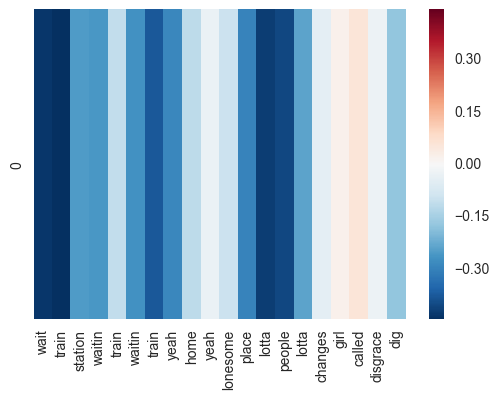

In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

i = 0

#sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
ax = sns.heatmap(np.transpose(z[i].data.numpy())[0:1,:], xticklabels  = [inv[x-1] for x in idx] )
